In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.nn import Sequential, Conv2d, BatchNorm2d, BatchNorm1d, ReLU, MaxPool2d, Flatten, Linear, Dropout, MSELoss
from  torchsummary import summary
from torchmetrics import SpearmanCorrCoef, PearsonCorrCoef
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

import random
random.seed(913)

import time

import sys
sys.path.append('/data/scratch/rdeng/enhancer_project/ipython_notebooks/')
from helper import IOHelper, SequenceHelper, utils 

# np.set_printoptions(threshold=sys.maxsize)

# training device: gpu or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is {}".format(device))

The device is cpu


### Funtions to load data

In [3]:
# function to convert only one piece of sequence to np.array
from typing import Any, Callable, Dict, Optional, Text, Union, Iterable

def one_hot_encode(sequence: str,
                   alphabet: str = 'ACGT',
                   neutral_alphabet: str = 'N',
                   neutral_value: Any = 0,
                   dtype=np.float32) -> np.ndarray:
    """
    One-hot encode for a sequence.
    A -> [1,0,0,0]
    C -> [0,1,0,0]
    G -> [0,0,1,0]
    T -> [0,0,0,1]
    N -> [0,0,0,0]
    """
    def to_uint8(string):
        return np.frombuffer(string.encode('ascii'), dtype=np.uint8)
    hash_table = np.zeros((np.iinfo(np.uint8).max, len(alphabet)), dtype=dtype)
    hash_table[to_uint8(alphabet)] = np.eye(len(alphabet), dtype=dtype)
    hash_table[to_uint8(neutral_alphabet)] = neutral_value
    hash_table = hash_table.astype(dtype)
    return hash_table[to_uint8(sequence)]


# function to generate all sequences to np.array (one-hot encoding matrix)
def generate_sequence_matrix(input_fasta):
    """
    After the function of one_hot_encode,
    convert the whole dateset to one_hot encoding matrix
    """
    sequence_matrix = []
    for i in range(0,len(input_fasta.sequence)):
        snippet = one_hot_encode(input_fasta.sequence[i])

        arr_pre = 1000
        arr_len = len(snippet)
        arr_int = int((arr_pre-arr_len)/2)
        arr_ceil = math.ceil((arr_pre-arr_len)/2)
        
        snippet=np.pad(snippet, [(arr_int, arr_ceil), (0, 0)], mode='constant')
        sequence_matrix.append(snippet)
        
    sequence_matrix=np.array(sequence_matrix)
    return sequence_matrix


# convert np.array to tensor
def prepare_tensor(X_test, Y_test):
    """
    convert np.array to tensor
    """
    tensor_x = torch.Tensor(X_test).permute(0,2,1).unsqueeze(2) # convert input: [batch, 1000, 4] -> [batch, 4, 1, 1000]
    tensor_y = torch.Tensor(Y_test).unsqueeze(1) # add one dimension in targets: [batch] -> [batch, 1]
    tensor_data = TensorDataset(tensor_x, tensor_y)
    return tensor_data

# function to load sequences and enhancer activity
def create_dataset(set, batch_size, task):
    """
    Load sequences and enhancer activity,
    convert to tensor type as the input of model
    """
    # Read fasta files
    file_seq = str("/data/scratch/rdeng/enhancer_project/data/train_set/Sequences_" + set + ".fa")
    input_fasta = IOHelper.get_fastas_from_file(file_seq, uppercase=True)

    # Convert sequence to one hot encoding matrix
    seq_matrix = generate_sequence_matrix(input_fasta)
        
    X = np.nan_to_num(seq_matrix) # Replace NaN with zero and infinity with large finite numbers
    X_reshaped = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

    Activity = pd.read_table("/data/scratch/rdeng/enhancer_project/data/train_set/Sequences_activity_" + set + ".txt")
    
    # choose task and create the target
    if task == "NSC":
        Y = Activity.NSC_log2_enrichment
    elif task == "ESC":
        Y = Activity.ESC_log2_enrichment
    else:
        print("Please provide the correct task ID: NSC or ESC")
   
    tensor_data = prepare_tensor(X_reshaped, Y)
    tensor_size = len(tensor_data)
    tensor_dataloader = DataLoader(tensor_data, batch_size)
    print("the {} data size is {}".format(set, len(tensor_data)))

    return tensor_dataloader


### Define EarlyStopping class

In [3]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, trace_func=print, task="NSC"):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.task=task
#         self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, task)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, task)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, task):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func("Validation loss decreased ({:.5f} --> {:.5f}).  Saving model ...".format(self.val_loss_min, val_loss))
        torch.save(model.state_dict(), "/data/scratch/rdeng/enhancer_project/model/checkpoint_{}.pth".format(task))
        self.val_loss_min = val_loss

### Build deep learning model

In [4]:
# Construct CNN model

class CNN_STARR(nn.Module):
    """
    CNN model: 4 convolution layers followed with two linear layers. forward two heads.
    """
    def __init__(self):
        super(CNN_STARR, self).__init__()
        self.model = Sequential(
            Conv2d(4, 128, (1,11), padding="same"),
            BatchNorm2d(128),
            ReLU(),
            MaxPool2d((1,2), (1,2)),
            Conv2d(128, 256, (1,9), padding="same"),
            BatchNorm2d(256),
            ReLU(),
            MaxPool2d((1,2), (1,2)),
            Conv2d(256, 512, (1,7), padding="same"),
            BatchNorm2d(512),
            ReLU(),
           MaxPool2d((1,2), (1,2)),
#             Conv1d(512, 1024, 3, padding=1),
#             BatchNorm1d(1024),
#             ReLU(),
#             MaxPool1d(2),
            Flatten(),
            Linear(64000, 1024),
            BatchNorm1d(1024),
            ReLU(),
            Dropout(0.4),
            Linear(1024, 1024),
            BatchNorm1d(1024),
            ReLU(),
            Dropout(0.4),
            Linear(1024, 1)
        )
        
    def forward(self, x):
        
        x = self.model(x)
        return x

    
cnn_starr = CNN_STARR()
cnn_starr.to(device)

print(cnn_starr)
summary(cnn_starr, input_size = (4, 1, 1000), batch_size = 128)


CNN_STARR(
  (model): Sequential(
    (0): Conv2d(4, 128, kernel_size=(1, 11), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(1, 9), stride=(1, 1), padding=same)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(1, 7), stride=(1, 1), padding=same)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=64000, out_features=1024, bias=True)
    (14): BatchNorm1d(1024, eps

### Specify Loss function and Optimizer

In [5]:
# loss function
loss_fn = MSELoss()
loss_fn.to(device)

# optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(cnn_starr.parameters(), lr = learning_rate)


### Train the model using EarlyStopping

In [6]:
def train_model(model, batch_size=128, patience=10, epochs=100, task="NSC"):
    
    start_time = time.time()    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping_object
    early_stopping = EarlyStopping(patience, verbose = True)

    for epoch in range(epochs):
        #################
        #Train the model#
        #################
        
        ### index: 0 is NSC, index: 1 is ESC ###
        model.train()
        for batch, data in enumerate(train_dataloader):
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            # loss function
            loss = loss_fn(outputs, targets)
            # record training loss
            train_losses.append(loss.item())
            
            # optimize model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        ####################
        #Validate the model#
        ####################
        model.eval() # pre model for evaluation
        with torch.no_grad():
            for batch, data in enumerate(valid_dataloader):
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                valid_losses.append(loss.item() )

        # print training/validation statisctics
        # calculte average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print("[ {} / {} ], train_loss: {:.5f}, valid_loss {:.5f}".format(epoch+1, epochs, train_loss, valid_loss))
        
        end_time = time.time()
        duration_time = end_time - start_time
        print("---------training time: {:.2f}s---------".format(duration_time))        
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decrease
        # and if it hasm it will make a checkpoint of the current model
        early_stopping(valid_loss, model,)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load("/data/scratch/rdeng/enhancer_project/model/checkpoint_{}.pth".format(task)))
    return model, avg_train_losses, avg_valid_losses


### Function to visualiz the loss and the Early Stopping Checkpoint

In [7]:
def loss_fig(train_loss, valid_loss, task):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 1) # consistent scale
    plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("/data/scratch/rdeng/enhancer_project/plots/loss_{}.pdf".format(task), dpi=300, bbox_inches='tight')

### Evaluating the model
#### Model performace: mean squared error (MSE), Person (PCC) and Spearman (SCC) correlation coefficients

In [8]:
def summmary_statistic(set, dataloader, main_model, task):
    
    # initialize loss
    test_loss = 0.0
    whole_preds = []
    whole_preds = []
    whole_targets = []
    whole_targets = []

    main_model.eval() # pre model for evaluation
    with torch.no_grad():
        for batch, data in enumerate(dataloader):
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = main_model(inputs)

            # return the whole dataset of targets and preds
            whole_targets.append(targets)
            whole_preds.append(outputs)

    whole_targets = torch.cat(whole_targets, dim = 0)
    whole_targets = whole_targets.squeeze().cpu().detach().numpy()

    whole_preds = torch.cat(whole_preds, dim = 0)
    whole_preds = whole_preds.cpu().detach().numpy()

    MSE = mean_squared_error(whole_targets, whole_preds.squeeze(1))
    pearon = stats.pearsonr(whole_targets, whole_preds.squeeze(1))
    spearman = stats.spearmanr(whole_targets, whole_preds.squeeze(1))

    # summary data for NSC

    print("---------Summary on {} data---------".format(set))
    print("the MSE of {}: {:.5f}".format(task, MSE))
    print("the pearson r of {}: {:.5f}".format(task, pearon[0]))
    print("the spearman r of {}: {:.5f}".format(task, spearman[0]))

    # plot correlation
    df = pd.DataFrame({
        'targets':whole_targets,
        'preds': whole_preds.squeeze(1)
    })
    
    utils.density_scatter(x=df.targets, y=df.preds, bins = [1500,1500],
                          dot_size = 5, color_map = 'turbo', 
                          save="/data/scratch/rdeng/enhancer_project/plots/{} correlation on {} data.pdf".format(task, set),
                          title="The correlation of {} data".format(set))


### Run the pipline

the Test data size is 29624
---------Summary on Test data---------
the MSE of NSC: 0.16438
the pearson r of NSC: 0.43223
the spearman r of NSC: 0.42636


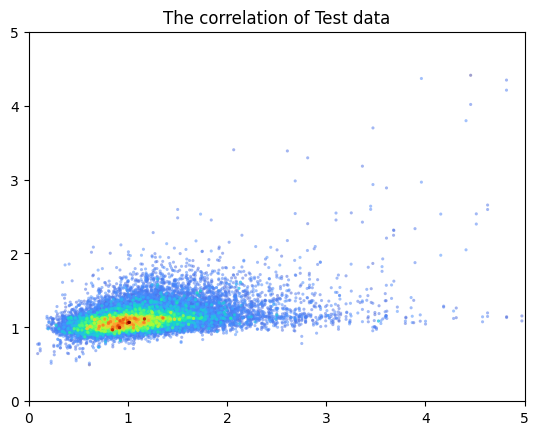

In [12]:
batch_size = 128
epochs = 100
patience = 20

# define the task
global task
task = "NSC"

# create data
train_dataloader = create_dataset("Train", batch_size, task)
valid_dataloader = create_dataset("Valid", batch_size, task)
test_dataloader = create_dataset("Test", batch_size, task)

# train model
cnn_starr, train_loss, valid_loss = train_model(cnn_starr, batch_size, patience, epochs, task)

# plot Train and Valid loss
loss_fig(train_loss, valid_loss, task)

# summary statistics
# cnn_starr.load_state_dict(torch.load("/data/scratch/rdeng/enhancer_project/model/checkpoint_NSC_212697.2D.pth".format(task), map_location=torch.device('cpu')))
summmary_statistic("Train", train_dataloader, cnn_starr, task)
summmary_statistic("Valid", valid_dataloader, cnn_starr, task)
summmary_statistic("Test", test_dataloader, cnn_starr, task)


In [30]:
def combine_df(cell, set):
    
    file_seq = str("/data/scratch/rdeng/enhancer_project/data/train_set/Sequences_" + set + ".fa")
    input_fasta = IOHelper.get_fastas_from_file(file_seq, uppercase=True)
    
    targets = np.load("/data/scratch/rdeng/enhancer_project/ipython_notebooks/2D/preds_targets/targets_" + cell + "_" + set + ".npy")
    preds = np.load("/data/scratch/rdeng/enhancer_project/ipython_notebooks/2D/preds_targets/preds_" + cell + "_" + set + ".npy")
    DF_targets = pd.DataFrame(targets)
    DF_preds = pd.DataFrame(preds)

    DF_merged = pd.concat([input_fasta, DF_targets, DF_preds], axis=1)
    DF_merged.columns = ['location', 'sequence', 'targets', 'preds']

    DF_merged = DF_merged[~DF_merged.location.str.contains("Reversed")]
    
    return DF_merged

In [72]:
test_nsc = combine_df("ESC", "Test")
valid_nsc = combine_df("ESC", "Valid")
train_nsc = combine_df("ESC", "Train")
whole_nsc = pd.concat([test_nsc, valid_nsc, train_nsc], axis=0)

whole_nsc = whole_nsc[['location', 'targets', 'preds']]
whole_nsc.to_csv('/data/scratch/rdeng/enhancer_project/ipython_notebooks/2D/preds_targets/whole_ESC.csv', index = False)
# whole_nsc[['location','start']] = whole_nsc['location'].str.split(':',expand=True)
# whole_nsc[['start','end']] = whole_nsc['start'].str.split('-',expand=True)


# whole_nsc = whole_nsc.sort_values(by=['location', 'start'], ascending=[True, True])
# whole_nsc = whole_nsc[['location', 'start', 'end', 'targets', 'preds']]